# Get started

This notebook contains the simple examples of time series forecasting pipeline
using etna_ts library.

**Table of Contents**

* [Creating TSDataset](#chapter1)
* [Plotting](#chapter2)
* [Forecast single time series](#chapter3)
    * [Simple forecast](#section_3_1)
    * [Prophet](#section_3_2)
    * [Catboost](#section_3_3)
* [Forecast multiple time series](#chapter4)

## 1. Creating TSDataset <a class="anchor" id="chapter1"></a>

Let's load and look at the dataset

In [1]:
import pandas as pd

In [2]:
original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


etna_ts is strict about data format:
* column we want to predict should be called `target`
* column with datatime data should be called `timestamp`
* because etna-ts is always ready to work with multiple time series, column `segment` is also compulsory

Our library works with the special data structure TSDataset. So, before starting anything, we need to convert the classical DataFrame to TSDataset.

Let's rename first

In [3]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


Time to convert to TSDataset!

To do this, we initially need to convert the classical DataFrame to the special format.

In [4]:
from etna.datasets.tsdataset import TSDataset

In [5]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


Now we can construct the TSDataset.

Additionally to passing dataframe we should specify frequency of our data.
In this case it is monthly data.

In [6]:
ts = TSDataset(df, freq='1M')

/home/marti/projects/etna-time-series-library/etna/datasets/tsdataset.py:32: UserWarning: You probably set wrong freq. Discovered freq in you data is MS, you set 1M
  warnings.warn(


Oups. Let's fix that

In [7]:
ts = TSDataset(df, freq='MS')

## 2. Plotting <a class="anchor" id="chapter2"></a>

Let's take a look at the time series in the dataset

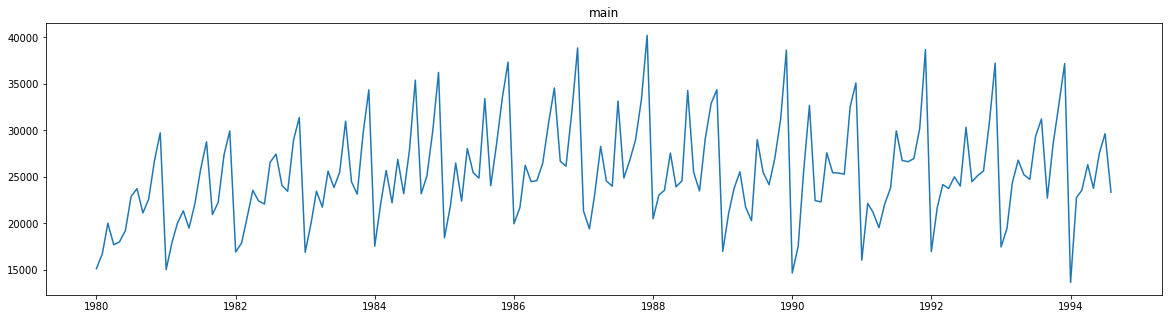

In [8]:
ts.plot()

## 3. Forecasting single time series <a class="anchor" id="chapter3"></a>

Our library contains a wide range of different models for time series forecasting. Let's look at some of them.

### 3.1 Simple forecast<a class="anchor" id="section_3_1"></a>
Let's predict the monthly values in 1994 in our dataset using the ```NaiveModel```

In [9]:
train_ts, test_ts = ts.train_test_split(train_start='1980-01-01',
                                        train_end='1993-12-01',
                                        test_start='1994-01-01',
                                        test_end='1994-08-01')

In [10]:
HORIZON = 8
from etna.models import NaiveModel

#Fit the model
model = NaiveModel(lag=12)
model.fit(train_ts)

#Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

Now let's look at a metric and plot the prediction.
All the methods already built-in in etna-ts.

In [11]:
from etna.metrics import SMAPE

In [12]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 11.492045838249387}

In [13]:
from etna.analysis import plot_forecast

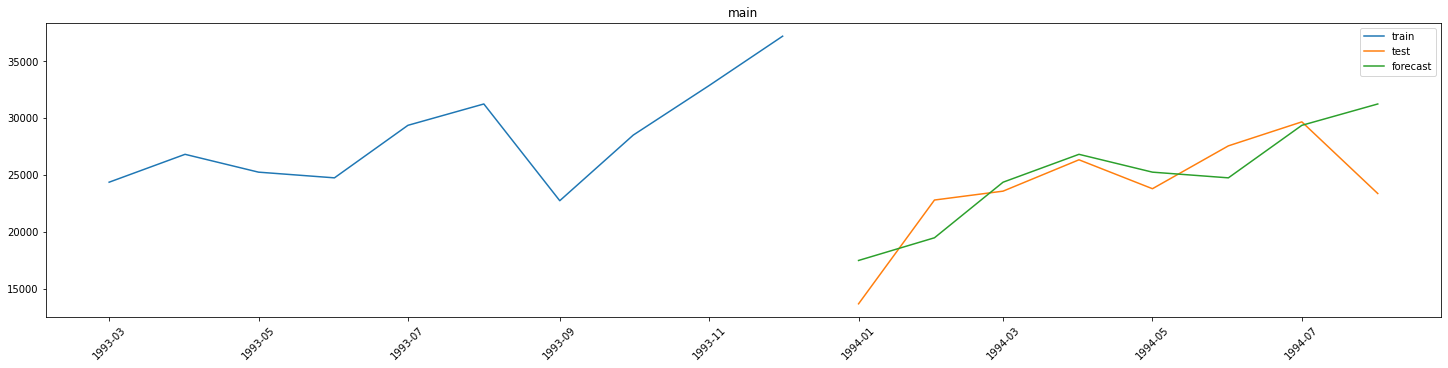

In [14]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Prophet<a class="anchor" id="section_3_2"></a>

Now try to improve the forecast and predict the values with the Facebook Prophet.

In [15]:
from etna.models import ProphetModel

model = ProphetModel()
model.fit(train_ts)

#Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.75778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       409.431   0.000868181       75.9007   1.007e-05       0.001      145  LS failed, Hessian reset 
      99        409.49   0.000113926       67.8321           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       409.589   0.000655446       91.5345   8.013e-06       0.001      267  LS failed, Hessian reset 
     199       409.645   0.000136875       90.6374           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       409.649   4.99708e-06       67.2726   7.088e-08       0.001      395  LS failed, Hessian reset 
     251        409.65    8.2682e-09       51.8513     0.08515     0.08515      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

In [16]:
smape(y_true=test_ts, y_pred=forecast_ts)


{'main': 10.53096836366393}

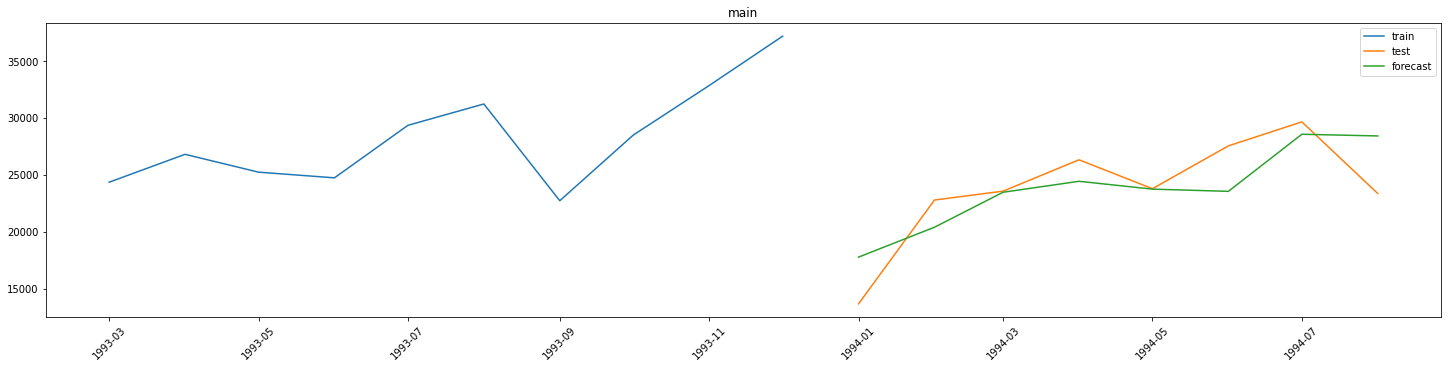

In [17]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

### 3.2 Catboost<a class="anchor" id="section_3_3"></a>
And finally let's try the Catboost model.

Also etna-ts has wide range of transforms you may apply to your data.

Here how it is done:

In [18]:
from etna.transforms.lags import LagTransform

lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
train_ts.fit_transform([lags])

In [19]:
from etna.models import CatBoostModelMultiSegment

model = CatBoostModelMultiSegment()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [20]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 9.396224125263625}

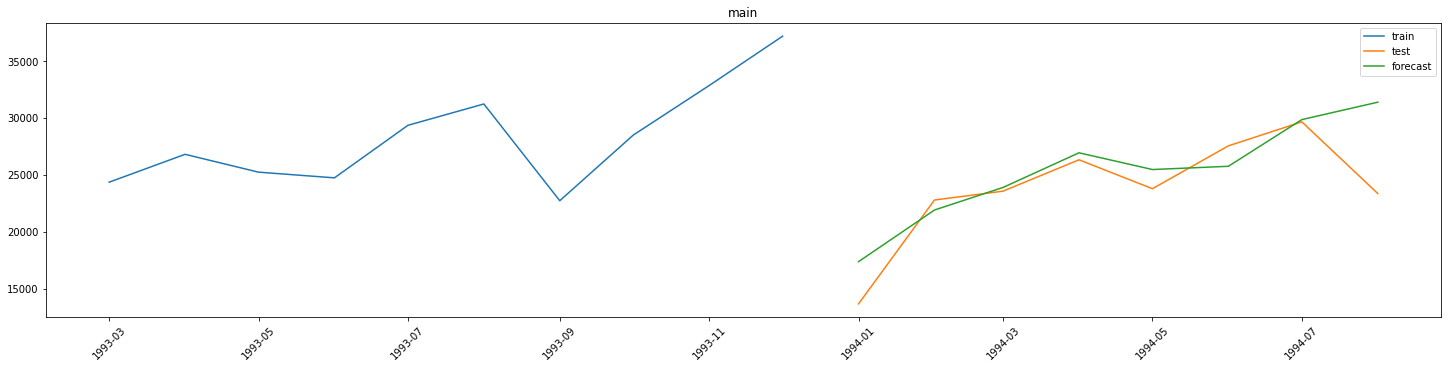

In [21]:
from etna.analysis import plot_forecast

train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

## 3. Forecasting multiple time series <a class="anchor" id="chapter4"></a>

In this section you may see example of how easily etna-ts works
with multiple time series and get acquainted with other transforms etna-ts contains.

In [22]:
original_df = pd.read_csv("data/example_dataset.csv")
original_df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


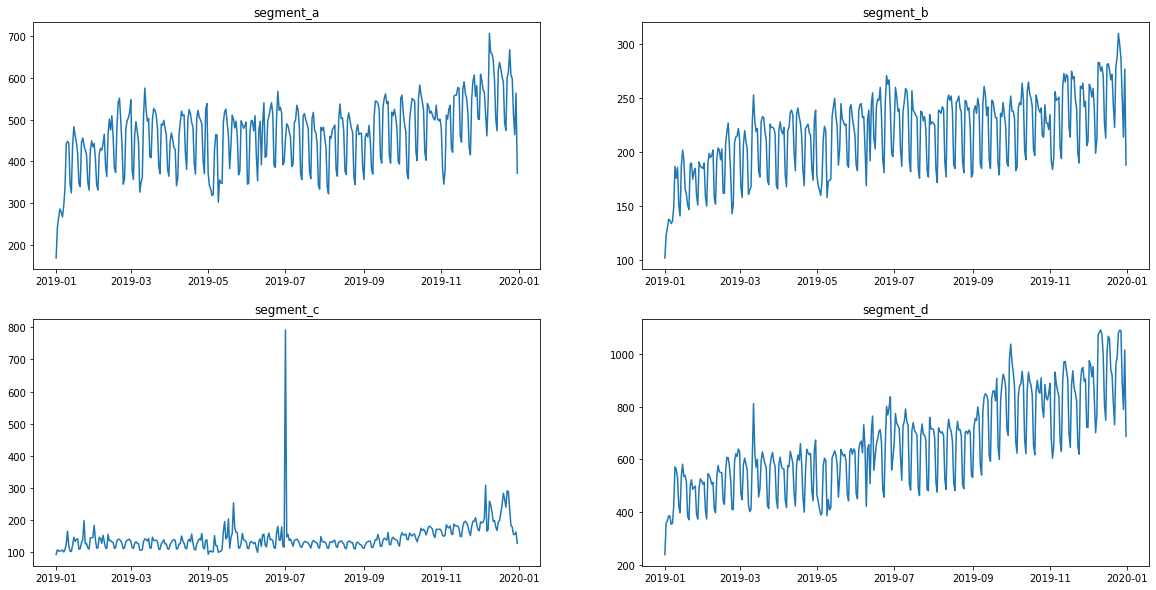

In [23]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [24]:
import warnings

from etna.transforms import MeanTransform, LagTransform, LogTransform, \
    SegmentEncoderTransform, DateFlagsTransform, LinearTrendTransform

warnings.filterwarnings("ignore")

log = LogTransform(in_column="target")
trend = LinearTrendTransform(in_column="target")
seg = SegmentEncoderTransform()

lags = LagTransform(in_column="target", lags=list(range(30, 96, 1)))
d_flags = DateFlagsTransform(day_number_in_week=True,
                             day_number_in_month=True,
                             week_number_in_month=True,
                             week_number_in_year=True,
                             month_number_in_year=True,
                             year_number=True,
                             special_days_in_week=[5, 6])
mean30 = MeanTransform(in_column="target", window=30, out_postfix="_mean30")

In [25]:
HORIZON = 31
train_ts, test_ts = ts.train_test_split(train_start='2019-01-01',
                                        train_end='2019-11-30',
                                        test_start='2019-12-01',
                                        test_end='2019-12-31')
train_ts.fit_transform([log, trend, lags, d_flags, seg, mean30])

In [26]:
from etna.models import CatBoostModelMultiSegment

model = CatBoostModelMultiSegment()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)

In [27]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_b': 5.840525600106394,
 'segment_a': 10.508858857869512,
 'segment_d': 8.798755250322673,
 'segment_c': 21.91878589613088}

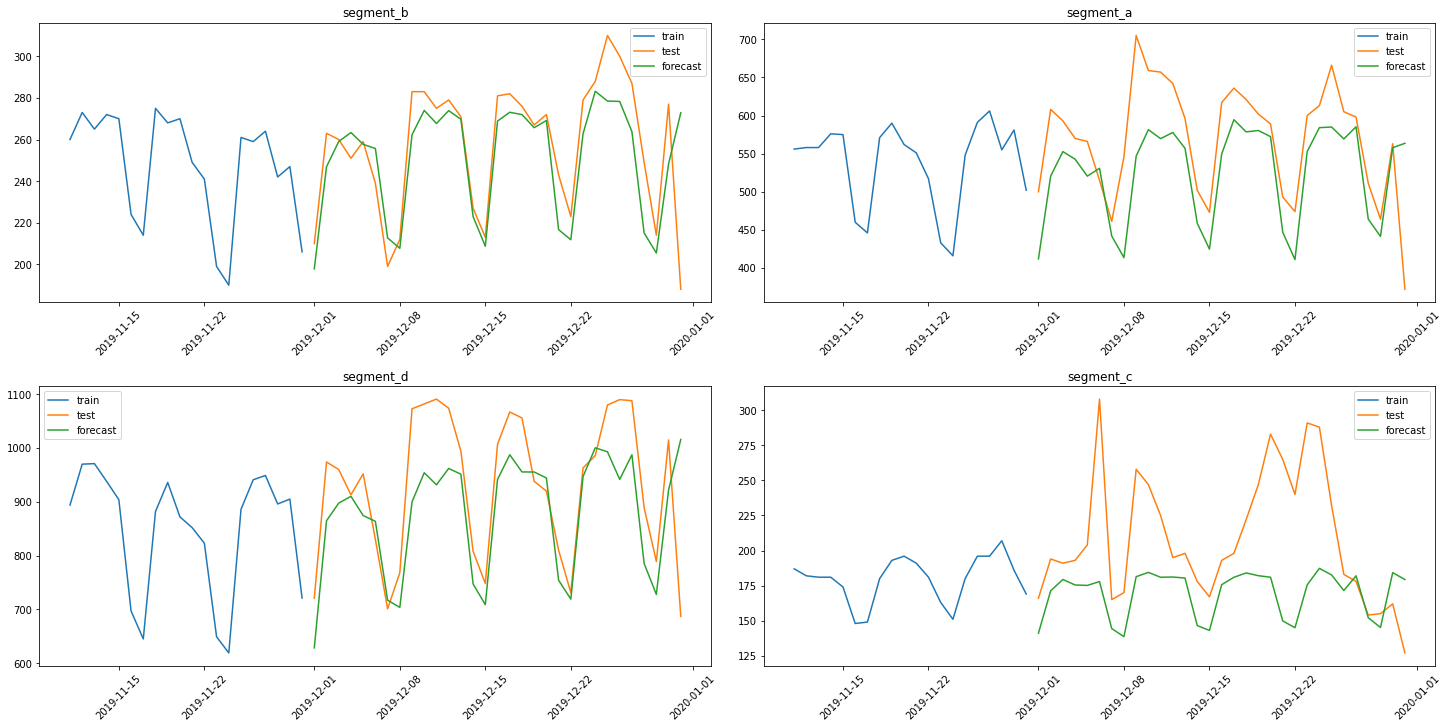

In [28]:
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)